# Analysis: Clustering Sentences

## Post Annotation and Aggregation

*January 2023*

Cluster sentences of metadata descriptions to see what patterns, if any, appear.

*TO DO: add additional metadata fields (collection, language, date, annotation_id, label, etc.) to see if helps with analysis of clustering results*

***

**Table of Contents**
 
[0.](#0) Data Preparation

[1.](#1) Clustering with K-Means

[2.](#2) Clustering with DBSCAN

***

**References**

For k-Means and DBSCAN: 
* Jurczyk, Thomas (2021) [Clustering with Scikit-Learn in Python](https://programminghistorian.org/en/lessons/clustering-with-scikit-learn-in-python).  The Programming Historian.  https://doi.org/10/46430/phen0094

***

## 0. Data Preparation

Load libraries:

In [2]:
import utils, config

import re, os
import numpy as np
import pandas as pd

# For working with text data
from nltk.stem import WordNetLemmatizer, PorterStemmer

# For clustering
from sklearn.preprocessing import StandardScaler as SS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN               # algorithms
from sklearn.decomposition import PCA                    # dimensionality reduction
from sklearn.metrics import silhouette_score             # to eval cohesion/separation in a cluster
from sklearn.neighbors import NearestNeighbors           # to get optimal epsilon (neighborhood distance) value

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# from yellowbrick.cluster import SilhouetteVisualizer  #--> installed inside and outside virtual env, still not working...

Load sentence data:

In [32]:
df = pd.read_csv(config.crc_meta_path+"description_sentences.csv", index_col=0)
df = df.loc[df.field != "Identifier"] # Ignore the Identifier field rows
df = df[["description_id", "field", "sentences", "file"]]
subdf = pd.DataFrame()
subdf[["eadid", "suffix"]] = df["file"].str.split("_", expand=True)
df.insert(len(df.columns), "eadid", subdf["eadid"])
df = df.drop(columns="file")
df.head()

,description_id,field,sentences,eadid
1,1,Title,Title:\nPapers of The Very Rev Prof James Whyt...,AA5
2,2,Scope and Contents,"Scope and Contents:\nSermons and addresses, 19...",AA5
3,3,Biographical / Historical,Biographical / Historical:\nProfessor James Ai...,AA5
3,3,Biographical / Historical,He was educated at Daniel Stewart's College an...,AA5
3,3,Biographical / Historical,After his ordination he spent three years as a...,AA5


In [59]:
df.loc[df.eadid.isna()].shape

(0, 4)

In [54]:
df_meta = pd.read_csv(config.crc_meta_path+"CRC_units-grouped-by-fonds_clean.csv", index_col=0)
df_meta.head()

,eadid,unit_title,unit_identifier,unique_language,unique_date,unique_geography
0,Coll-1064,"['Papers of Professor Walter Ledermann', '1 (3...","['Coll-1064', 'Coll-1064/1', 'Coll-1064/2', 'C...",['English'],"['1937-01-01 - 1954-12-31', '1937-02-02 - 1938...","['Edinburgh (Scotland)', 'St Andrews (Scotland..."
1,Coll-31,['Drawings from the Office of Sir Rowand Ander...,"['Coll-31', 'Coll-31/1', 'Coll-31/1/1', 'Coll-...",['English'],"['1814-01-01 - 1924-12-31', '1874-01-01 - 1905...",['']
2,Coll-51,['Papers of Sir Roderick Impey Murchison and h...,"['Coll-51', 'Coll-51/1', 'Coll-51/2', 'Coll-51...",['English'],"['1771-01-01 - 1935-12-31', '1723-01-01 - 1935...","['Calcutta (India)', 'Europe', 'Tarradale (Sco..."
3,Coll-204,"['Lecture Notes of John Robison', 'Introductio...","['Coll-204', 'Coll-204/1', 'Coll-204/2', 'Coll...","['English', 'Russian', 'Latin', 'French']","['1779-01-01 - 1801-12-31', '1779-01-01 - 1801...","['Edinburgh (Scotland)', 'Stirlingshire Scotla..."
4,Coll-206,['Records of the Wernerian Natural History Soc...,"['Coll-206', 'Coll-206/1', 'Coll-206/1/1', 'Co...",['English'],"['1808-01-01 - 1858-12-31', '1808-01-12 - 1858...","['Edinburgh (Scotland)', 'Freiburg im Breisgau..."


In [55]:
# df_meta.loc[df_meta.unique_language.isna()] # 1 row
df_meta["unique_language"] = df_meta.unique_language.fillna("['']")

In [56]:
list_cols = list(df_meta.columns)[1:]
df_meta
for col in list_cols:
    str_col = df_meta[col]
    list_col = [row[2:-2].split("', '") for row in str_col]
    df_meta = df_meta.drop(columns=[col])
    df_meta.insert((list_cols.index(col)+1), col, list_col)

print(type(list(df_meta[col])[0]))
print(type(list(df_meta[col])[0][0]))

<class 'list'>
<class 'str'>


Let's summarize the data:

In [4]:
text_col = "sentences"

In [13]:
print("Total sentences:", df.shape[0])
print("Unique sentences:", len(df[text_col].unique()))

Total sentences: 41692
Unique sentences: 34744


In [14]:
df.field.value_counts()

Scope and Contents           20573
Title                        16870
Biographical / Historical     3921
Processing Information         328
Name: field, dtype: int64

In [15]:
print("Total descriptions:",len(list(df.description_id.unique())))

Total descriptions: 27570


***

Optionally, we can reduce the words in the text to their root form using stemming or lemmatization.


In [5]:
stemmer = PorterStemmer()
text_list = list(df[text_col])
text_stems = [stemmer.stem(text) for text in text_list]
print(text_stems[0])

title:
papers of the very rev prof james whyte (1920-2005)


In [6]:
lmtzr = WordNetLemmatizer()
text_list = list(df[text_col])
text_lemmas = [lmtzr.lemmatize(text) for text in text_list]
print(text_lemmas[0])

Title:
Papers of The Very Rev Prof James Whyte (1920-2005)


In [7]:
df.insert(len(df.columns), "sent_stems", text_stems)
df.insert(len(df.columns), "sent_lemmas", text_lemmas)
df.head()

,description_id,field,sentences,sent_stems,sent_lemmas
1,1,Title,Title:\nPapers of The Very Rev Prof James Whyt...,title:\npapers of the very rev prof james whyt...,Title:\nPapers of The Very Rev Prof James Whyt...
2,2,Scope and Contents,"Scope and Contents:\nSermons and addresses, 19...","scope and contents:\nsermons and addresses, 19...","Scope and Contents:\nSermons and addresses, 19..."
3,3,Biographical / Historical,Biographical / Historical:\nProfessor James Ai...,biographical / historical:\nprofessor james ai...,Biographical / Historical:\nProfessor James Ai...
3,3,Biographical / Historical,He was educated at Daniel Stewart's College an...,he was educated at daniel stewart's college an...,He was educated at Daniel Stewart's College an...
3,3,Biographical / Historical,After his ordination he spent three years as a...,after his ordination he spent three years as a...,After his ordination he spent three years as a...


***

Set the maximum number of features at 250, and only consider words that appear in at least 10 different documents but no more than 200.  Additionally, allow for bigrams (such as "19th century") and trigrams (such as "Mrs. Norman Macleod").  We'll have the sklearn Vectorizer filter out stop words (such as "the" and "and"), as well.

*Question: How are the features selected if a maximum is set?*

In [8]:
col_name = "sent_lemmas" #sent_stems, sentences
tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=250, strip_accents="unicode", min_df=10, max_df=200, stop_words="english")
tfidf_array = tfidf.fit_transform(df[col_name])
df_tfidf = pd.DataFrame(tfidf_array.toarray(), index=df.index, columns=tfidf.get_feature_names())
df_tfidf.describe()

,11,12,13,14,15,16,17,18,19,1904,...,ts signed,undated,united,university library,using,wales,women,works,york,zealand
count,41692.000000,41692.000000,41692.000000,41692.000000,41692.000000,41692.000000,41692.000000,41692.000000,41692.00000,41692.000000,...,41692.000000,41692.000000,41692.000000,41692.000000,41692.000000,41692.000000,41692.000000,41692.000000,41692.000000,41692.000000
mean,0.003103,0.003187,0.002257,0.002340,0.002715,0.002219,0.002077,0.002173,0.00236,0.002623,...,0.002603,0.002515,0.002174,0.001346,0.002317,0.002429,0.003027,0.002078,0.002318,0.001854
std,0.049364,0.050020,0.041732,0.041877,0.044578,0.040597,0.040806,0.040357,0.04264,0.046197,...,0.041131,0.043872,0.038708,0.023970,0.043329,0.043129,0.049727,0.039866,0.043363,0.033978
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.707107


In [9]:
df_tfidf.shape

(41692, 250)

Next, use Principal Component Analysis (PCA) to reduce the dimensions in our dataset from 250 to 10.

In [10]:
pca = PCA(n_components=10, whiten=False, random_state=22)
sents_pca = pca.fit_transform(df_tfidf)
df_pca = pd.DataFrame(data=sents_pca)

/afs/inf.ed.ac.uk/user/s15/s1545703/repos/gender-bias/analysis/Clustering/utils.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


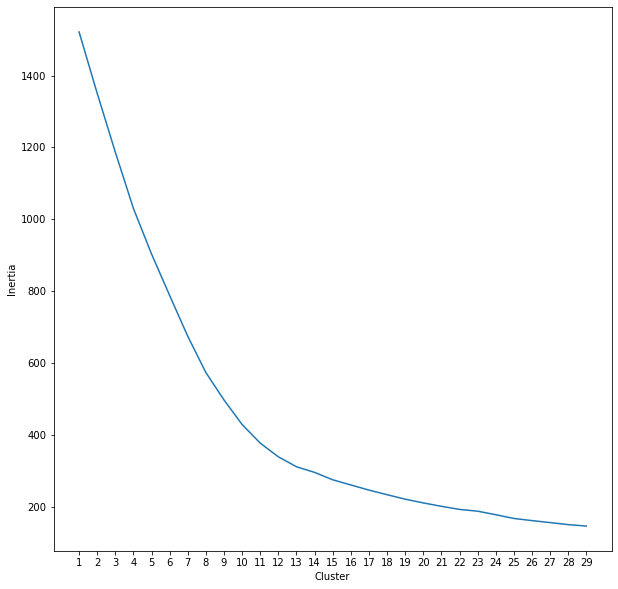

In [26]:
utils.elbowPlot(range(1,30), df_pca)

In [27]:
n_clusters = 10

In [28]:
kmeans = KMeans(n_clusters=n_clusters, random_state=22)
clusters = kmeans.fit_predict(df_pca)
df_clustered = df.copy()
df_clustered.insert(len(df_clustered.columns), "cluster", clusters)
df_clustered.head()

,description_id,field,sentences,sent_stems,sent_lemmas,cluster
1,1,Title,Title:\nPapers of The Very Rev Prof James Whyt...,title:\npapers of the very rev prof james whyt...,Title:\nPapers of The Very Rev Prof James Whyt...,1
2,2,Scope and Contents,"Scope and Contents:\nSermons and addresses, 19...","scope and contents:\nsermons and addresses, 19...","Scope and Contents:\nSermons and addresses, 19...",1
3,3,Biographical / Historical,Biographical / Historical:\nProfessor James Ai...,biographical / historical:\nprofessor james ai...,Biographical / Historical:\nProfessor James Ai...,1
3,3,Biographical / Historical,He was educated at Daniel Stewart's College an...,he was educated at daniel stewart's college an...,He was educated at Daniel Stewart's College an...,1
3,3,Biographical / Historical,After his ordination he spent three years as a...,after his ordination he spent three years as a...,After his ordination he spent three years as a...,1


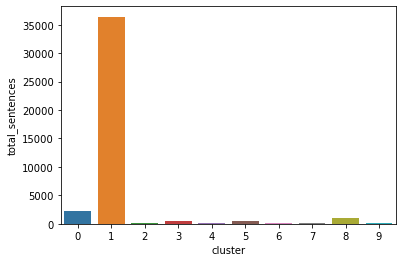

In [31]:
cluster_counts = df_clustered.groupby("cluster").size().reset_index(name="total_sentences")
sns.barplot(x="cluster", y="total_sentences", data=cluster_counts)

Reduce further to 2 dimensions for visualization: 

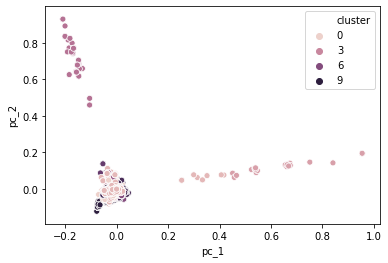

In [36]:
pca = PCA(n_components=2, whiten=False, random_state=22)
clusters2 = pca.fit_transform(df_tfidf)
df_pca2 = pd.DataFrame(data=clusters2, columns=["pc_1", "pc_2"])
df_pca2.insert(len(df_pca2.columns), "cluster", clusters)
sns.scatterplot(x="pc_1", y="pc_2", hue="cluster", data=df_pca2)

<a id="1.2"></a>
### 1.2 DBSCAN on Annotated Text Spans

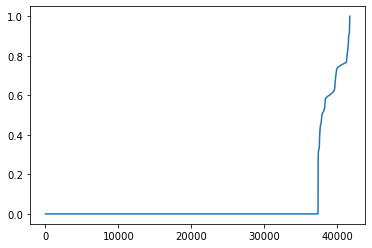

In [39]:
utils.findOptimalEps(2, df_tfidf)

Let's try changing the TFIDF vectorizer parameters to see if we get a chart with a better curve to help us choose an epsilon value:

In [37]:
# tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=300, strip_accents="unicode", min_df=50, max_df=300, stop_words="english")
# tfidf_array = tfidf.fit_transform(df["text"])  #df["text_stems"], df["text_lemmas"]
# df_tfidf = pd.DataFrame(tfidf_array.toarray(), index=df.index, columns=tfidf.get_feature_names())
# print(df_tfidf.shape)
# print(list(df_tfidf.columns)[:10])

In [38]:
# utils.findOptimalEps(2, df_tfidf)

In [12]:
eps_value = 0.7

In [ ]:
# Kernel crashes when running this:
# -------------------------------------------
# dbscan = DBSCAN(eps=eps_value, metric="euclidean")  # change to cosine distance if use TFIDF DataFrame
# dbscan_clusters = dbscan.fit_predict(df_pca)
# df_dbscan = df.copy()
# df_dbscan.insert(len(df_dbscan.columns), "cluster_pca", dbscan_clusters)
# df_dbscan["cluster_pca"].unique()

In [15]:
dbscan = DBSCAN(eps=eps_value, metric="cosine")  # change to euclidean distance if use PCA DataFrame
dbscan_clusters = dbscan.fit_predict(df_tfidf)
df_dbscan = df.copy()
df_dbscan.insert(len(df_dbscan.columns), "cluster_tfidf", dbscan_clusters)
df_dbscan["cluster_tfidf"].unique()

array([ 0, -1,  1])

In [18]:
df_dbscan.groupby("cluster_tfidf").size().reset_index(name="sentence_count")

,cluster_tfidf,sentence_count
0,-1,20999
1,0,20566
2,1,127


In [ ]:
tfidf_cluster_neg1 = df_dbscan.loc[df_dbscan.cluster_tfidf == -1]
tfidf_cluster_0 = df_dbscan.loc[df_dbscan.cluster_tfidf == 0]
tfidf_cluster_1 = df_dbscan.loc[df_dbscan.cluster_tfidf == 1]